Klein Gordon EDP

2025-06-25 01:24:36.249923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 01:24:38.338886: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-25 01:24:38.339028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 01:24:38.345061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 01:24:39.301531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 01:24:52.599441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.266060 s

'compile' took 1.726379 s



2025-06-25 01:25:17.964329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.76e-01, 6.66e-01, 2.25e-01, 7.74e-03]    [2.19e-01, 6.66e-01, 2.25e-01, 7.74e-03]    [1.16e+00]    
1000      [7.91e-02, 1.55e-01, 4.89e-03, 1.37e-01]    [6.88e-02, 1.55e-01, 4.89e-03, 1.37e-01]    [5.46e-01]    
2000      [2.55e-02, 1.22e-01, 4.62e-03, 1.56e-01]    [2.23e-02, 1.22e-01, 4.62e-03, 1.56e-01]    [4.78e-01]    
3000      [4.96e-03, 1.06e-01, 4.70e-03, 1.49e-01]    [4.21e-03, 1.06e-01, 4.70e-03, 1.49e-01]    [4.37e-01]    
4000      [3.02e-03, 1.05e-01, 4.74e-03, 1.49e-01]    [2.62e-03, 1.05e-01, 4.74e-03, 1.49e-01]    [4.38e-01]    
5000      [2.34e-03, 1.04e-01, 4.77e-03, 1.49e-01]    [2.11e-03, 1.04e-01, 4.77e-03, 1.49e-01]    [4.38e-01]    
6000      [2.14e-03, 1.04e-01, 4.70e-03, 1.49e-01]    [2.01e-03, 1.04e-01, 4.70e-03, 1.49e-01]    [4.36e-01]    
7000      [2.06e-03, 1.03e-01, 4.54e-03, 1.49e-01]    [1.99e-03, 1.03e-01, 4.

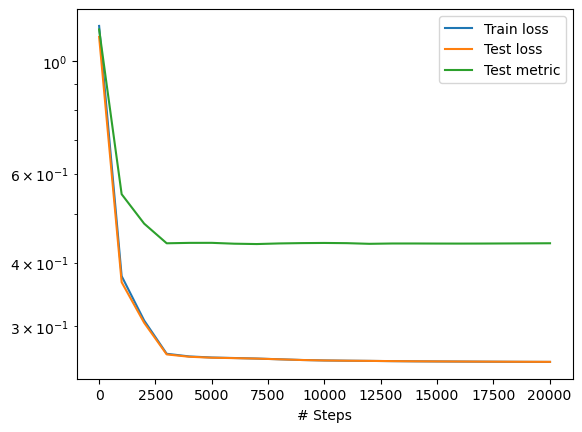

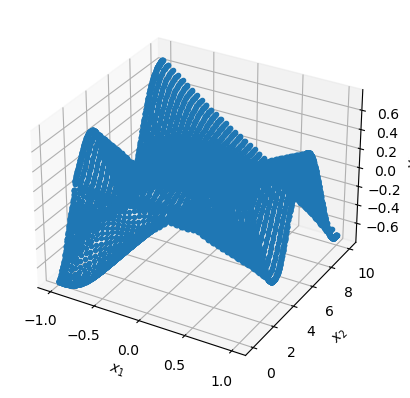

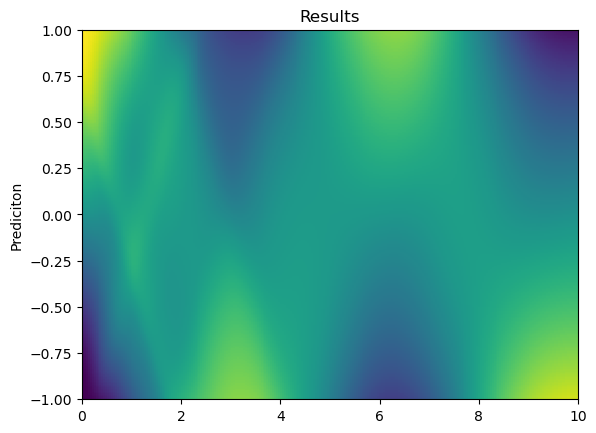

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define sine function
if dde.backend.backend_name in ["tensorflow.compat.v1", "tensorflow"]:
    from deepxde.backend import tf

    cos = tf.math.cos
elif dde.backend.backend_name == "paddle":
    import paddle

    cos = paddle.cos


def pde(x, y):
    alpha, beta, gamma, k = -1, 0, 1, 2
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    x, t = x[:, 0:1], x[:, 1:2]
    return (
        dy_tt
        + alpha * dy_xx
        + beta * y
        + gamma * (y ** k)
        + x * cos(t)
        - (x ** 2) * (cos(t) ** 2)
    )


def func(x):
    return x[:, 0:1] * np.cos(x[:, 1:2])


bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=30000,
    num_boundary=1500,
    num_initial=1500,
    solution=func,
    num_test=6000,
)

layer_size = [2] + [40] * 2 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], decay=("inverse time", 3000, 0.9)
)
model.train(iterations=20000)
model.compile("L-BFGS", metrics=["l2 relative error"])
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

x = np.linspace(-1, 1, 256)
t = np.linspace(0, 10, 256)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None)

v = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

fig, ax = plt.subplots()
ax.set_title("Results")
ax.set_ylabel("Prediciton")
ax.imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, 10, -1, 1],
    origin="lower",
    aspect="auto",
)
plt.show()